# Subspace Inference

Bayesian inference methods generate uncertainty information in Neural Networks (DNN). However, using Bayesian inference in Deep Neural network is challenging due to the large dimension of parameter space. The subspace inference method is used to generate uncertainty information of DNN parameters subspace.

Subspace Inference package is implemented based on the following publication:

Izmailov, P., Maddox, W. J., Kirichenko, P., Garipov, T., Vetrov, D., & Wilson, A. G. (2020, August). Subspace inference for Bayesian deep learning. In Uncertainty in Artificial Intelligence (pp. 1169-1179). PMLR.

### Subspace Inference package can be installed by using the following commands:
```julia
using Pkg
Pkg.add(url = "https://github.com/efmanu/SubspaceInference.jl.git")
```

### This notebook contains uncertainty generation of simple multilayer perceptron
The is DNN contains two inputs and one output. The hidden layer sizes are as follows [200 50 50]

Start using subspace inference using in Julia.

In [1]:
#use packages

using NPZ
using Plots
using Flux
using Flux: Data.DataLoader
using Flux: @epochs
using Plots
using BSON: @save
using BSON: @load
using Zygote
using Statistics
using SubspaceInference

┌ Debug: Initializing CUDA driver
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\src\initialization.jl:89
┌ Debug: Trying to use artifacts...
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\bindeps.jl:126
┌ Debug: Selecting artifacts based on driver compatibility 11.1.0
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\bindeps.jl:135
┌ Debug: CUDA toolkit identified as 11.0.3 (providing nvdisasm 11.0.221)
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\discovery.jl:344
┌ Debug: Using CUDA 11.0.3 from an artifact at C:\Users\manoos\.julia\artifacts\796965836d2cdbc7c12c2d896800285d3c266cef
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\bindeps.jl:176
┌ Debug: Using CUDNN from an artifact at C:\Users\manoos\.julia\artifacts\c68026379752255051652cc354aab4c74bd21dec
└ @ CUDA C:\Users\manoos\.julia\packages\CUDA\dZvbp\deps\bindeps.jl:267
┌ Debug: Using CUTENSOR from an artifact at C:\Users\manoos\.julia\artifacts\804435c7dbe9d002d6caa0a8b3596d11a6faa77

### Set root of project folder
This folder contains data and trained networks.

In [2]:
root = pwd();
cd(root);

### Plot Data
This loaded data conatains two columns, one is taken as <em>x</em> and <em>y</em>. The <em>x</em>  is converted to features using <em>features</em> function. Then zipped using <em>DataLoader</em> available with <em>Flux</em>

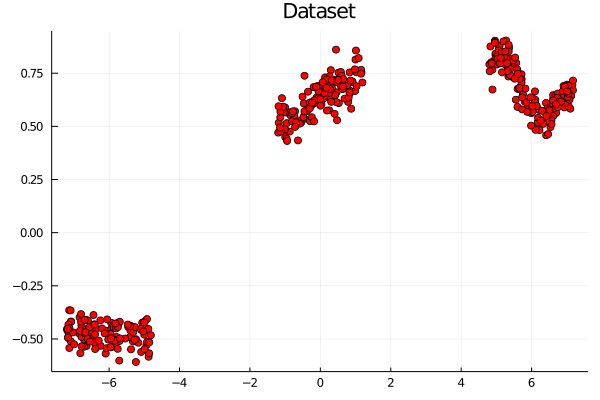

In [3]:
#laod data
data_ld = npzread("data.npy");
x, y = (data_ld[:, 1]', data_ld[:, 2]');
function features(x)
    return vcat(x./2, (x./2).^2)
end

f = features(x);
data =  DataLoader(f,y, batchsize=50, shuffle=true);

#plot data
scatter(data_ld[:,1],data_ld[:,2],color=["red"], title="Dataset", legend=false)

### DNN Model setup
The simple multilayer perceptron is created as using Dense layer. This DNN contains 2 inputs, 1 output and hidden layers of [200,50,50] size. All layers other than the output layer contains the ***ReLu*** activation function.

In [4]:
m = Chain(
		Dense(2,200,Flux.relu), 
		Dense(200,50,Flux.relu),
		Dense(50,50,Flux.relu),
		Dense(50,50,Flux.relu),
		Dense(50,1),
	)

Chain(Dense(2, 200, relu), Dense(200, 50, relu), Dense(50, 50, relu), Dense(50, 50, relu), Dense(50, 1))

The model is destructed to extract weights and function as below

In [5]:
θ, re = Flux.destructure(m);

### Cost function
Gaussian likelihood cost function is implemented for training as:

In [6]:
L(x, y) = Flux.Losses.mse(m(x), y)/2;

The parameters are loaded as:

In [7]:
ps = Flux.params(m);

### Optimizer
The optimizer used in this project is Stochastic gradient descent with momentum value:

In [8]:
opt = Momentum(0.01, 0.95);

### Pretrain weights ad save
The DNN needs to pre-train and save for subspace inference as below. NB: training takes little time. This package examples contain some trained weights.

In [9]:
# epochs = 3000
# for j in 1:5
#    m = Chain(
#            Dense(2,200,Flux.relu),
#            Dense(200,50,Flux.relu),
#            Dense(50,50,Flux.relu),
#            Dense(50,50,Flux.relu),
#            Dense(50,1),
#    )
#    ps = Flux.params(m)
#    SubspaceInference.pretrain(epochs, L, ps, data, opt, lr_init =0.01, print_freq= 100)
#    @save "model_weights_$(j).bson" ps
# end

### Plot different SGD solutions

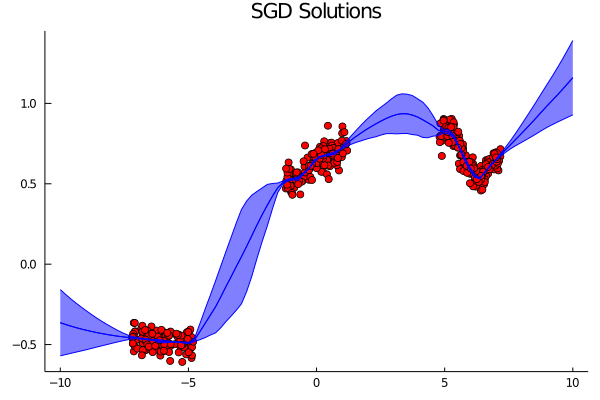

In [10]:
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,5)
for i in 1:5
	@load "model_weights_$(i).bson" ps
	Flux.loadparams!(m, ps)
	out = m(inp)
	trajectories[:, i] = out'
end
SubspaceInference.plot_predictive(data_ld, trajectories, z, title="SGD Solutions")


### Load pre-trained weight
The pre-trained weights can be found in the examples folder.

In [11]:
i = 1;
@load "model_weights_$(i).bson" ps;
Flux.loadparams!(m, ps);

### Generate uncertainty of weights using
The <em>weight_uncertainty</em> function from the ***SubspaceInference*** package is used to generate parameter space uncertainty

In [12]:
M = 10 #Rank of PCA or Maximum columns in deviation matrix
T = 10 #Steps
itr = 100
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, itr = 100, T=10, M=10)


Traing loss: 0.001074567111855229 Epoch: 1
Traing loss: 0.0010690018417070669 Epoch: 2
Traing loss: 0.001508626359936791 Epoch: 3
Traing loss: 0.0015010327620909702 Epoch: 4
Traing loss: 0.0009782939627678822 Epoch: 5
Traing loss: 0.0013608636652305162 Epoch: 6
Traing loss: 0.0011903730924247124 Epoch: 7
Traing loss: 0.001008902766313895 Epoch: 8
Traing loss: 0.0015783766979436643 Epoch: 9
Traing loss: 0.0016223963457705892 Epoch: 10


┌ Info: Found initial step size
│   ϵ = 25.6
└ @ Turing.Inference C:\Users\manoos\.julia\packages\Turing\O1Pn0\src\inference\hmc.jl:195
Sampling: 100%|█████████████████████████████████████████| Time: 0:01:30


15801×100 Array{Float64,2}:
 -0.155378   -0.155385    -0.155386   …  -0.155373   -0.155398   -0.155371
 -0.086516   -0.0865118   -0.0865118     -0.0865135  -0.0865122  -0.0865111
 -0.0614437  -0.0612471   -0.0615167     -0.0613147  -0.0615101  -0.0613434
  0.0259222   0.0257691    0.0255874      0.025713    0.025744    0.0254696
  0.0484348   0.0484107    0.048423       0.048417    0.0484261   0.0484065
  0.120655    0.120781     0.120812   …   0.120765    0.120735    0.120889
  0.140675    0.140644     0.14065        0.140632    0.140676    0.140609
  0.01015     0.00988817   0.0100175      0.0099029   0.0101277   0.00977701
  0.117143    0.117215     0.117059       0.117145    0.117114    0.117091
  0.0219755   0.0216659    0.0218561      0.021646    0.0220194   0.0214915
 -0.232567   -0.232783    -0.233319   …  -0.232994   -0.232927   -0.233551
  0.12335     0.123367     0.123357       0.123368    0.12335     0.123374
  0.156882    0.156894     0.156884       0.156891    0.156882   

### Plot uncertainty using different trajectories that generated using PCA with NUTS

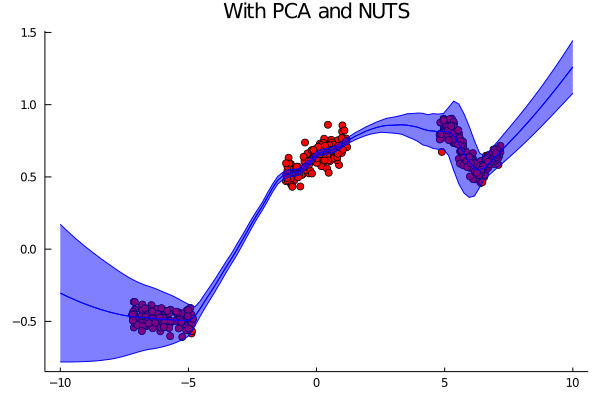

In [13]:
z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end
SubspaceInference.plot_predictive(data_ld, trajectories, z, title="With PCA and NUTS")

### PCA with HMC

Traing loss: 0.0011797284970714993 Epoch: 1
Traing loss: 0.0011012581872877902 Epoch: 2
Traing loss: 0.0017141839697189098 Epoch: 3
Traing loss: 0.0009080299195515718 Epoch: 4
Traing loss: 0.0007678754154648804 Epoch: 5
Traing loss: 0.0010908690163265967 Epoch: 6
Traing loss: 0.001311125215248339 Epoch: 7
Traing loss: 0.0009788906165725385 Epoch: 8
Traing loss: 0.0012888119288519473 Epoch: 9
Traing loss: 0.0015991581017997358 Epoch: 10

Sampling:   2%|█                                        |  ETA: 0:00:35

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:32


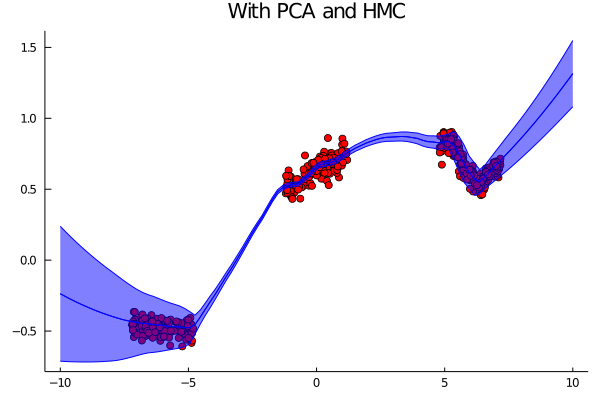

In [14]:
using Turing
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)
i = 1
@load "model_weights_$(i).bson" ps
Flux.loadparams!(m, ps)

M = 10
T = 10
itr = 100
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, 
	prior_dist = Normal(0.0,10.0), σ_l = 10.0, alg = HMC(0.65,5), 
	itr = 100, T=10, M=10)

z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

SubspaceInference.plot_predictive(data_ld, trajectories, z, title="With PCA and HMC")

Traing loss: 0.0013375148703678086 Epoch: 1
Traing loss: 0.0011106083939565626 Epoch: 2
Traing loss: 0.0011282310441847266 Epoch: 3
Traing loss: 0.0016715085645553263 Epoch: 4
Traing loss: 0.0013863068541258006 Epoch: 5
Traing loss: 0.0009424678138518416 Epoch: 6
Traing loss: 0.001358618884971321 Epoch: 7
Traing loss: 0.0015672033433141142 Epoch: 8
Traing loss: 0.0007289448751431316 Epoch: 9
Traing loss: 0.0010658807432450334 Epoch: 10

Sampling:   2%|█                                        |  ETA: 0:00:30

Sampling: 100%|█████████████████████████████████████████| Time: 0:00:31


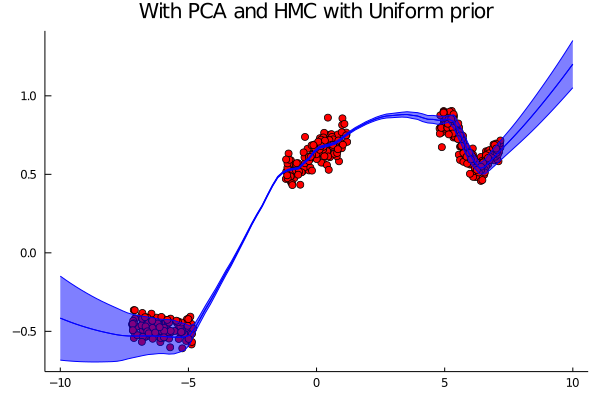

In [15]:
using Turing
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)
i = 1
@load "model_weights_$(i).bson" ps
Flux.loadparams!(m, ps)

M = 10
T = 10
itr = 100
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, 
	prior_dist = Uniform(0.0,10.0), σ_l = 10.0, alg = HMC(0.65,5), 
	itr = 100, T=10, M=10)

z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

SubspaceInference.plot_predictive(data_ld, trajectories, z, title="With PCA and HMC with Uniform prior")

### Plot uncertainty using different trajectories that generated using PCA with MH
This experiment is conducted with Uniform(0.0,10.0) as prior

Traing loss: 0.0008291139536309711 Epoch: 1
Traing loss: 0.0018485665647651128 Epoch: 2
Traing loss: 0.0010628504237614146 Epoch: 3
Traing loss: 0.0014396676881260361 Epoch: 4
Traing loss: 0.0012374133987227865 Epoch: 5
Traing loss: 0.0010286216256146829 Epoch: 6
Traing loss: 0.0011883182442431561 Epoch: 7
Traing loss: 0.001088588784361173 Epoch: 8
Traing loss: 0.0014124370343115622 Epoch: 9
Traing loss: 0.0014851457901109378 Epoch: 10


Sampling: 100%|█████████████████████████████████████████| Time: 0:00:01


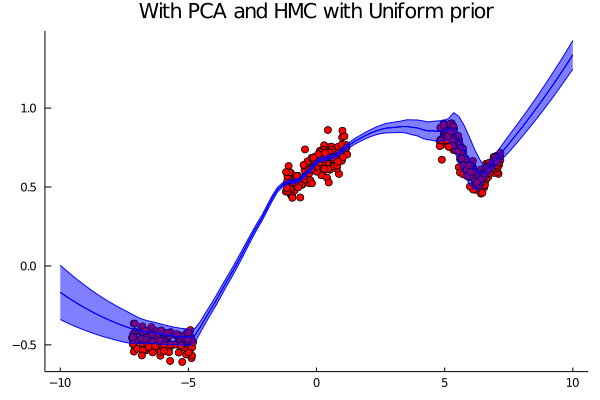

In [16]:
using Turing
m = Chain(
	Dense(2,200,Flux.relu), 
	Dense(200,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,50,Flux.relu),
	Dense(50,1),
)
i = 1
@load "model_weights_$(i).bson" ps
Flux.loadparams!(m, ps)

M = 10
T = 10
itr = 100
all_chain = SubspaceInference.weight_uncertainty(m, L, data, opt, 
	prior_dist = Uniform(0.0,10.0), σ_l = 10.0, alg = MH(), 
	itr = 100, T=10, M=10)

z = collect(range(-10.0, 10.0,length = 100))
inp = features(z')
trajectories = Array{Float64}(undef,100,itr)
for i in 1:itr
	m1 = re(all_chain[:,i])
	out = m1(inp)
	trajectories[:, i] = out'
end

SubspaceInference.plot_predictive(data_ld, trajectories, z, title="With PCA and HMC with Uniform prior")